# Text Summarization of Amazon Reviews 
Extractive summarization selects sentences directly from the document based on a scoring function to form a coherent summary. This method works by identifying important sections of the text cropping our and stitching together portios of the content to produce a condensed version. 
- Step 1: Text Preprocessing
    - To preprocess this data, clean the text and tokenize the sentences. This is done in the *Preprocessing* notebook. 
- Step 2: Sentence Embedding 
- Step 3: Clustering 
- Step 4: Extractive Summarization

In [2]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns
import random
import html
from IPython.display import display
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Text cleaning
import spacy 
nlp = spacy.load('en_core_web_sm')

# Text summarization 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize, tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.utils import get_stop_words
from sumy.summarizers.lex_rank import LexRankSummarizer 
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

from summarizer import Summarizer

## Load saved reviews and metadata csv files

In [4]:
merge_df = pd.read_csv('../data/merge_df_select.csv', low_memory = False, index_col = False)
# Remove null values in 'text' column 
merge_df = merge_df.dropna(subset=['text'])
# Remove rows where 'text' column contains empty strings
merge_df = merge_df[merge_df['text'].str.strip() != '']
# Reset the index of the DataFrame
merge_df.reset_index(drop=True, inplace=True)

print(f'Number of records: {len(merge_df)}')

Number of records: 2553766


## Filtering the dataframe to a specific brand or product

In [5]:
print(f"Unique store count: {merge_df['parent_asin'].nunique()}")
print('-----------')
merge_df['store'].value_counts().head(25)

Unique store count: 469542
-----------


store
Coleman                   32745
Fitbit                    19878
BalanceFrom               17187
Franklin Sports           11931
CamelBak                  11257
FOCO                       9891
WinCraft                   9865
Amazon Basics              9561
WILSON                     9279
Sunny Health & Fitness     8940
CAP Barbell                8608
Schwinn                    8415
Rico Industries            8116
Contigo                    7973
adidas                     7701
Northwest                  7061
SHIMANO                    7042
Razor                      7009
Speedo                     6922
Gaiam                      6711
Nalgene                    6510
Foxelli                    6426
BELL                       6266
Callaway                   6102
Yes4All                    6068
Name: count, dtype: int64

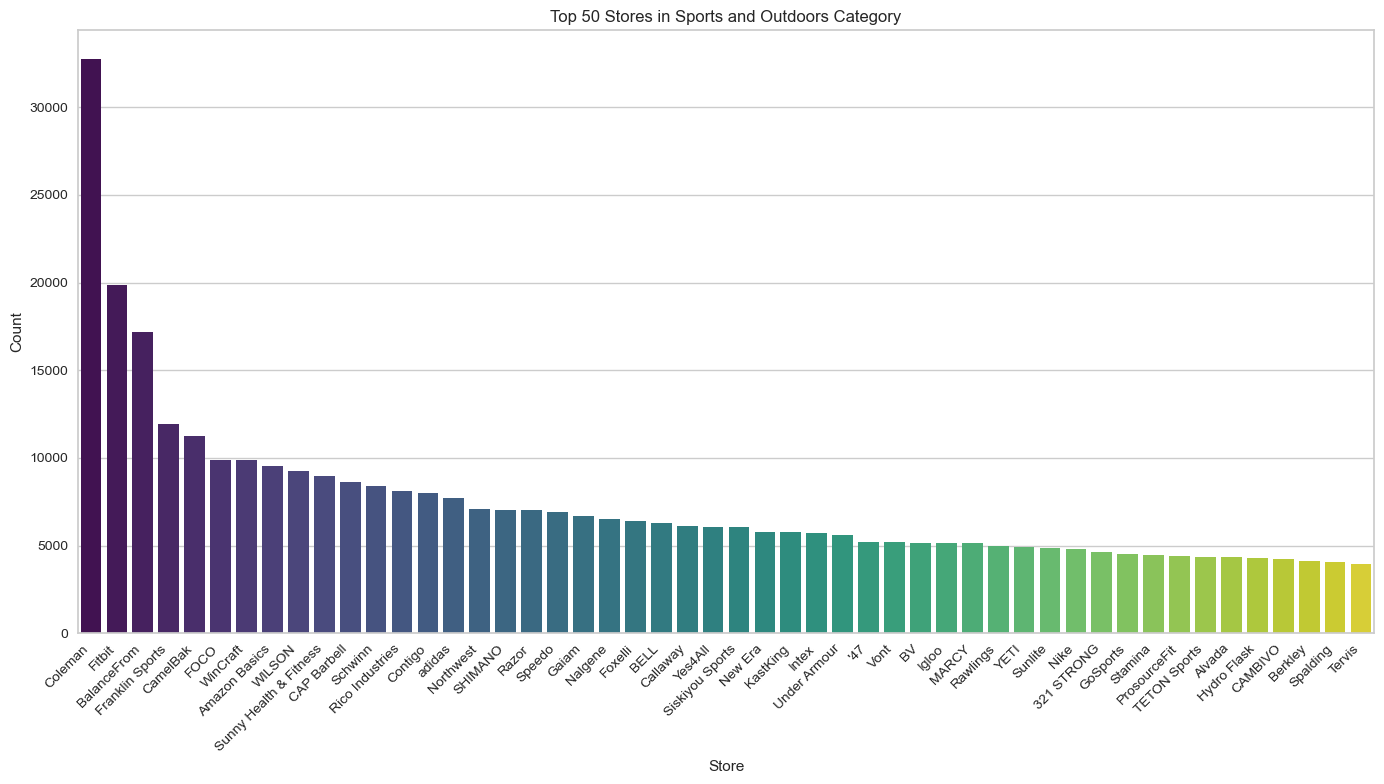

In [67]:
# Get the top 25 stores and their counts
store_counts = merge_df['store'].value_counts().head(50).reset_index()
store_counts.columns = ['store', 'count']

# Plot the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=store_counts, x='store', y='count', palette='viridis')
plt.title('Top 50 Stores in Sports and Outdoors Category')
plt.xlabel('Store')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust the padding between and around subplots
plt.savefig('../assets/top_50_stores_by_count.png', format='png', bbox_inches='tight')
plt.show()

In [79]:
merge_df['rating'].value_counts()

rating
5    1749983
4     352731
3     179356
1     165389
2     106307
Name: count, dtype: int64

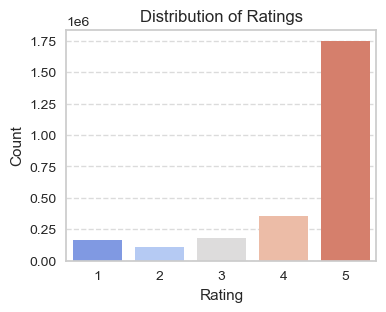

In [83]:
rating_counts = merge_df['rating'].value_counts()

# Create a bar plot using Seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='coolwarm')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../assets/ratings_distribution.png', bbox_inches='tight')
plt.show()

### Assigning a specific store

In [6]:
store = 'BalanceFrom'

filtered_df = merge_df.loc[merge_df['store'] == store].copy()
filtered_df.reset_index(drop=True, inplace=True)
print(f'Store is set to: {store}')

Store is set to: BalanceFrom


In [7]:
def generate_brand_report(df, store):
    """
    Generates a report for a specified store, including counts of unique parent and product IDs, 
    and statistics on reviews and ratings.
    """
    # Filter the DataFrame by the specified store
    filtered_df = df[df['store'] == store]
    print(f"Store: {store}")
    print('-----')

    # Count number of reviews
    complete_reviews_count = filtered_df['rating_number'].unique().sum()
    print(f"Number of reviews in complete Amazon dataset: {complete_reviews_count}")
    print(f"Number of reviews in df: {len(filtered_df)}")  # Some customers only include a title and rating to their reviews
    
    # Calculate the number of unique parent_asin values
    parent_asin_count = filtered_df['parent_asin'].nunique()
    print(f"Count of unique parent product IDs: {parent_asin_count}")
    
    # Count the number of unique asin values
    asin_count = filtered_df['asin'].nunique()
    print(f"Count of unique product ID's: {asin_count}")
    
    # Calculate the number of reviews and average review rating for each asin
    asin_reviews_ratings = filtered_df.groupby('parent_asin').agg({'average_rating': 'mean', 
                                                                   'rating_number': 'mean', 
                                                                  'price': ['min', 'max'], 
                                                                   'text': 'count'
                                                                }).reset_index()

    # Rename columns 
    asin_reviews_ratings.columns = ['parent_asin', 'average_rating', 'review_count', 'min_price', 'max_price', 'rev_count']
    
    # Create a composite score for each product
    asin_reviews_ratings['composite_score'] = asin_reviews_ratings['average_rating'] * asin_reviews_ratings['review_count']

    # Find the top and bottom ten products with the best and worst rating
    top_ten_best = asin_reviews_ratings.nlargest(10, 'composite_score')
    bottom_ten_worst = asin_reviews_ratings.nsmallest(10, 'composite_score')
    print('-----')
    print(f"Top ten products: \n {top_ten_best}")
    print('-----')
    print(f"Bottom ten products: \n {bottom_ten_worst}")

# Apply function
generate_brand_report(filtered_df, store)

Store: BalanceFrom
-----
Number of reviews in complete Amazon dataset: 528140
Number of reviews in df: 17187
Count of unique parent product IDs: 157
Count of unique product ID's: 449
-----
Top ten products: 
     parent_asin  average_rating  review_count min_price max_price  rev_count  composite_score
149  B0C5RBPW2Y             4.5       88491.0     18.99     18.99       7123         398209.5
119  B0B8T4M8KY             4.6       57411.0    129.99    129.99       2657         264090.6
118  B0B8SWT79R             4.5       41814.0     13.49     13.49        768         188163.0
140  B0C1Q6ZN7F             4.7       38259.0     29.98     29.98        628         179817.3
128  B0BKX3RTNC             4.6       38107.0     11.87     11.87        681         175292.2
115  B0B8DK52J1             4.6       34564.0     19.99     19.99        831         158994.4
104  B09XV43K48             4.4       27359.0      18.4      18.4        397         120379.6
136  B0BY55GNMT             4.6       1

In [8]:
def generate_random_examples(df, column, interest):
    """
    Generate three examples of random records with the specified interest. 
    
    Parameters: 
    df: DataFrame where the search will occur. 
    column: Column name to search within. 
    interest: Value to search for in the specified column. 
    """
    # Print average rating for parent_asin 
    interest_average_rating = df[df[column] == interest]['average_rating'].unique()
    print(f'Average rating: {interest_average_rating[0]}\n')
    # print(f'Categories: {df[df[column] == interest]["categories"].iloc[0]}\n')
    print(f'Details: {df[df[column] == interest]["details"].iloc[0]}\n')
    
    # Filter the Datadf[df[column] == interest]Frame based on the interest
    filtered_df = df[df[column] == interest]

    # Set number of examples 
    num_of_ex = 3 
    
    # Check if there are enough records to sample
    if len(filtered_df) < num_of_ex:
        print(f"Not enough records found for interest '{interest}'. Found {len(filtered_df)} records.")
        return
    
    # Randomly select three records
    random_examples = filtered_df.sample(n=num_of_ex)
    
    for i, row in random_examples.iterrows():
        print('-----')
        print(f'Rating: {row["rating"]}\n')
        print(f'Text: {row["text"]}\n')


In [9]:
# Apply random example generator for best products 
df = filtered_df
column = 'parent_asin'
interest = 'B0C5RBPW2Y'
generate_random_examples(df, column, interest)

Average rating: 4.5

Details: {'Item Package Dimensions L x W x H': '24.5 x 7 x 7 inches', 'Package Weight': '1.02 Kilograms', 'Item Dimensions  LxWxH': '71 x 24 x 0.5 inches', 'Item Weight': '1.8 Pounds', 'Brand Name': 'BalanceFrom', 'Model Name': 'BalanceFrom Go Yoga All Purpose', 'Color': 'Red', 'Material': 'Foam', 'Manufacturer': 'BalanceFrom - Exercise & Fitness', 'Part Number': 'BFGY-AP6RD', 'Style': 'Mat Only', 'Included Components': 'BalanceFrom GoYoga Exercise Yoga Mat^Yoga Mat Strap', 'Size': '71 Inch X 24 Inch', 'Sport Type': 'Yoga', 'Best Sellers Rank': {'Sports & Outdoors': 91, 'Yoga Mats': 2}, 'Date First Available': 'October 6, 2013', 'Brand': 'BalanceFrom', 'Product Care Instructions': 'Water,Soap', 'Product Dimensions': '71"L x 24"W x 0.5"Th'}

-----
Rating: 5

Text: Mat took a little while to get use to but it is comfortable and a great product

-----
Rating: 5

Text: I was very impressed with the quality of this item. I have used so many mats in the past that over a 

### Filtering to a specific product

In [10]:
product = 'B0C5RBPW2Y'

brand_df = filtered_df.loc[filtered_df['parent_asin'] == product].copy()
brand_df.reset_index(drop=True, inplace=True)
print(f'Product is set to: {product}')
print(f'Review count: {len(brand_df)}')
print(f'Details: {brand_df[brand_df["parent_asin"] == product]["details"][0]}\n')

Product is set to: B0C5RBPW2Y
Review count: 7123
Details: {'Item Package Dimensions L x W x H': '24.5 x 7 x 7 inches', 'Package Weight': '1.02 Kilograms', 'Item Dimensions  LxWxH': '71 x 24 x 0.5 inches', 'Item Weight': '1.8 Pounds', 'Brand Name': 'BalanceFrom', 'Model Name': 'BalanceFrom Go Yoga All Purpose', 'Color': 'Red', 'Material': 'Foam', 'Manufacturer': 'BalanceFrom - Exercise & Fitness', 'Part Number': 'BFGY-AP6RD', 'Style': 'Mat Only', 'Included Components': 'BalanceFrom GoYoga Exercise Yoga Mat^Yoga Mat Strap', 'Size': '71 Inch X 24 Inch', 'Sport Type': 'Yoga', 'Best Sellers Rank': {'Sports & Outdoors': 91, 'Yoga Mats': 2}, 'Date First Available': 'October 6, 2013', 'Brand': 'BalanceFrom', 'Product Care Instructions': 'Water,Soap', 'Product Dimensions': '71"L x 24"W x 0.5"Th'}



## Sentence Transformers library
Use Sentence BERT (SBERT) to convert each sentence into a vector. This helps capture the semantic meaning of each sentence. 

### Preprocess the text

In [90]:
random_row = brand_df.sample(3)
print(f'Rating: {random_row["rating"].iloc[0]}\n')
print(f'Text: {random_row["text"].iloc[0]}\n')
# print(f'Tokenized Sentences: {random_row["tokenized_sentences"].iloc[0]}\n')
print('----------')
print(f'Rating: {random_row["rating"].iloc[1]}\n')
print(f'Text: {random_row["text"].iloc[1]}\n')
# print(f'Tokenized Sentences: {random_row["tokenized_sentences"].iloc[1]}\n')
print('----------')
print(f'Rating: {random_row["rating"].iloc[2]}\n')
print(f'Text: {random_row["text"].iloc[2]}\n')
# print(f'Tokenized Sentences: {random_row["tokenized_sentences"].iloc[1]}\n')

Rating: 5

Text: Thickness softness and color are all great!

----------
Rating: 4

Text: This is my first yoga mat I have ever used. I ordered it for my college dorm room floor which hurt to work out on as it was tile. The mat does not slip on the floor but it could be thicker. It has a nice textured feeling.

----------
Rating: 5

Text: Great color and thickness. High quality I used it for the 1st time this morning and loved it.



In [27]:
st = time.process_time()
# Tokenize sentences and create a new column
brand_df['tokenized_sentences'] = brand_df['text'].apply(sent_tokenize)

# Create a list of lists from the tokenized sentences  
tokenized_sentences = brand_df['tokenized_sentences'].tolist()

# Create a single list of sentences by iterating over each sublist
sentences = []
for sublist in tokenized_sentences:
    sentences.extend(sublist)

# Remove run-on sentences in list of sentences (sentences with more than 30 words)
def count_words(sentence):
    return len(sentence.split())

filtered_sentences = [sentence for sentence in sentences if count_words(sentence) <= 20]

# Remove sentences that contain only punctuation marks
cleaned_sentences = [sentence for sentence in filtered_sentences if not re.fullmatch(r'[^\w\s]*', sentence)]

# Ensure each sentence ends with a period
processed_sentences = [
    sentence if sentence[-1] in '.!?' else sentence + '.' for sentence in cleaned_sentences
]

e = time.process_time()
print(f"Elapsed time: {e - st} seconds\n")

Elapsed time: 0.65625 seconds



### Creating sentence embeddings

In [29]:
st = time.process_time()

# Sentence Embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sentence_embeddings = model.encode(processed_sentences)

e = time.process_time()
print(f"Elapsed time: {e - st} seconds\n")

C:\Users\MJ\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Elapsed time: 383.96875 seconds



In [ ]:
# Sentence Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(processed_sentences)

### Clustering 
Use K-Means clustering to group the review sentences into a number of clusters called K clusters. K means clustering finds the best position for cluster centers, called centroids, and assign each data point to the nearest centroid. 
   
- The KElbowVisualizer is used to determined the best number of clusters (k) for K-means clustering by analyzing the variation within clusters for different values of k. The elbow point (where the WCSS starts to level off) shows the optimal number of clusters. Adding more clusters beyond that point doesn't significantly reduce WCSS.
- The Silhouette Visualizer is a tool that evaluates how well separated the clusters are and whether the assigned cluster labels are appropriate for the data.
    - Values close to 1 indicate that samples are well-matched to their own cluster and poorly matched to neighboring clusters.
    - Values around 0 indicate that samples are on or near the boudnary between clusters.
    - Negative values indicate that samples might be assigned to the wrong cluster.
    - The red dashed line represents the average silhouette score across all samples. Higher average means better-defined clusters.
    - The width of each cluster on the y-axis shows the size of the cluster. Uneven cluster sizes can be indicate imbalances in the dataset. 

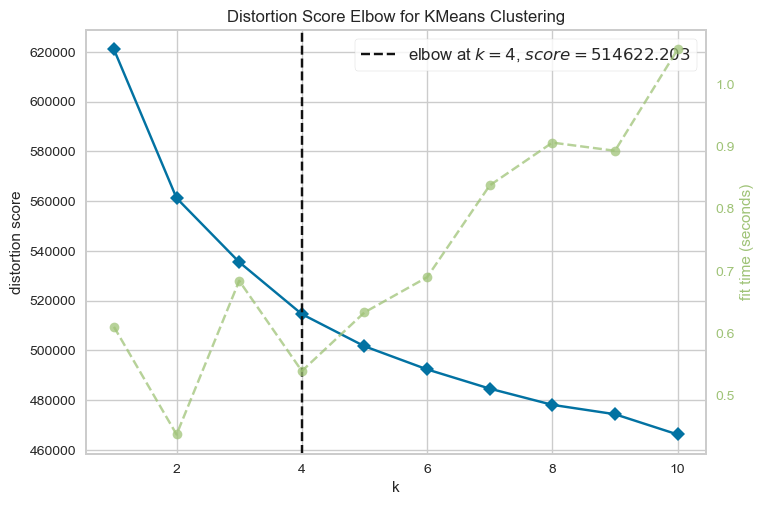

In [84]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,11))
 
visualizer.fit(sentence_embeddings) 

# Save the figure using matplotlib
visualizer.finalize()
plt.savefig('../assets/elbow_method1.png')

visualizer.show();  

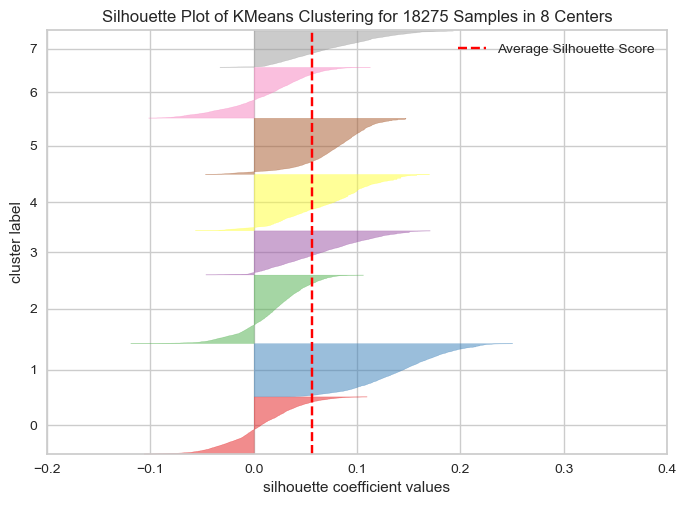

In [85]:
km = KMeans(random_state=42)
visualizer = SilhouetteVisualizer(km, k=(1,11))
 
visualizer.fit(sentence_embeddings) 

# Save the figure using matplotlib
visualizer.finalize()
plt.savefig('../assets/silhouette_method1.png')

visualizer.show();

In [33]:
num_clusters = 4  # Choose based on the elbow plot
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(sentence_embeddings)
labels = kmeans.labels_

KMeans parameters: 
- k = number of clusters 
- init = initialization method 
- max_iter = max number of iterations for each run 
- n_init = sets number of times the algorithm will be run with differet initial centroids
- random_state = ensures reproducibility

The K-means model is fitted to the sentence embeddings and the predicted labels are stored in y_kmeans. 

### Extractive Summarization with SBERT model

In [35]:
st = time.process_time()
clustered_sentences = [[] for _ in range(num_clusters)]

# Group sentences by cluster
for i, label in enumerate(labels):
    clustered_sentences[label].append(filtered_sentences[i])

representative_sentences = []
for i, cluster in enumerate(clustered_sentences):
    centroid = kmeans.cluster_centers_[i]
    closest_sentence = None
    closest_distance = float('inf')
    for sentence in cluster:
        sentence_embedding = model.encode([sentence])[0]
        distance = np.linalg.norm(sentence_embedding - centroid)
        if distance < closest_distance:
            closest_sentence = sentence
            closest_distance = distance
    representative_sentences.append(closest_sentence)

e = time.process_time()
print(f"Elapsed time: {e - st} seconds\n")

Elapsed time: 1329.984375 seconds



In [36]:
# Display the extractive summary
st = time.process_time()
for sentence in representative_sentences:
    print(sentence)
e = time.process_time()
print()
print(f"Elapsed time: {e - st} seconds\n")mih

But it is already looking a little beaten up after a few uses e.g.
Super thick and comfortable if youre looking for a yoga mat this is the one for you!
For the price too you get a good product.
It is soft and comfortable and just the right size.

Elapsed time: 0.0 seconds



### Create and display word clouds for bigrams and trigrams with known KMeans clusters
**Preprocess Text**: Remove words in stopwords list, lemmatize words, and remove non-alphabetic characters. Use the clean_data function. 

In [37]:
# Define stopwords
stopwords = spacy.lang.en.stop_words.STOP_WORDS
include_stopwords = {'would', 'I'}
stopwords |= include_stopwords
print('Original stopwords count:', len(stopwords))

def clean_data(tokenized_sentences):
    """
    Cleans and preprocesses tokenized sentences using spaCy.
    
    This function takes a list of tokenized sentences as input, converts each sentence to lowercase, 
    lemmatizes the words, and filters out stopwords. 
    The resulting cleaned tokenized sentences are returned as a list of lists. 
    """
    cleaned_sentences = []
    
    for sentence in tokenized_sentences:
        # Convert each tokenized sentence to lowercase
        sentence = sentence.lower()
        # Process the tokenized sentence with spaCy
        doc = nlp(sentence)
        # Lemmatize words and filter out stopwords
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        cleaned_text = " ".join(tokens)        
        cleaned_sentences.append(cleaned_text)
    
    return cleaned_sentences

Original stopwords count: 327


In [52]:
st = time.process_time()

# Preprocess the text for each cluster
# preprocessed_clusters = [clean_data(sentences) for sentences in clustered_sentences]

# Function to create and display word clouds for bigrams and trigrams
def create_wordcloud(ngram_range, preprocessed_clusters, cluster_num):
    cluster_text = ' '.join(preprocessed_clusters[cluster_num])
    
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform([cluster_text])
    freqs = X.sum(axis=0).A1
    indices = np.argsort(freqs)[::-1]
    features = vectorizer.get_feature_names_out()
    top_features = {features[i]: freqs[i] for i in indices[:50]}  # Get top 50 n-grams

    wordcloud = WordCloud(scale=3, 
                          width=800, 
                          height=400, 
                          background_color='white', 
                          colormap='twilight_shifted_r').generate_from_frequencies(top_features)
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_num} WordCloud ({"-".join(map(str, ngram_range))}gram)')
    # Save WordCloud as PNG
    plt.savefig(f'../assets/wordcloud_cluster_{cluster_num}_{"-".join(map(str, ngram_range))}gram.png', format='png', bbox_inches='tight')
    plt.show()

e = time.process_time()
print()
print(f"Elapsed time: {e - st} seconds\n")


Elapsed time: 0.0 seconds



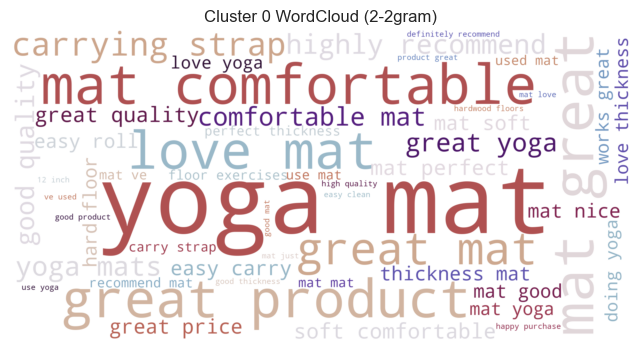

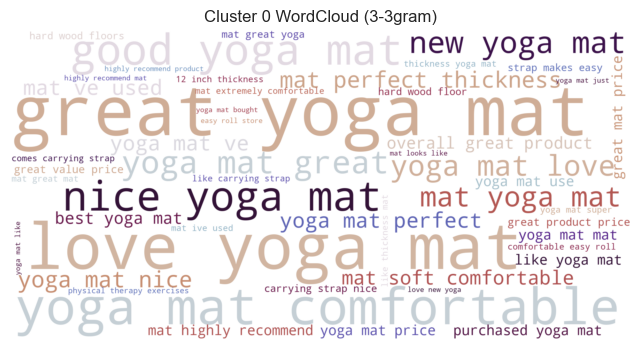

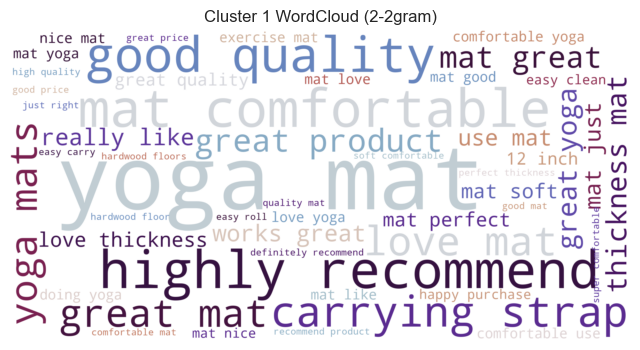

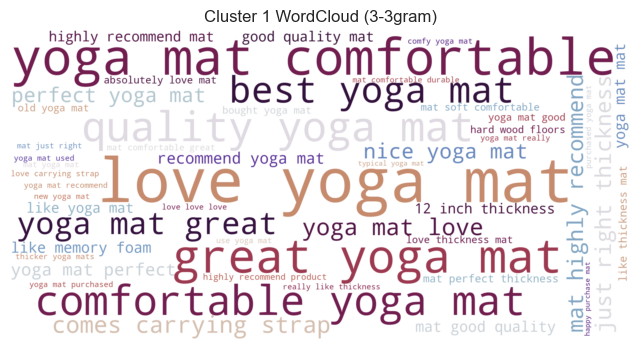

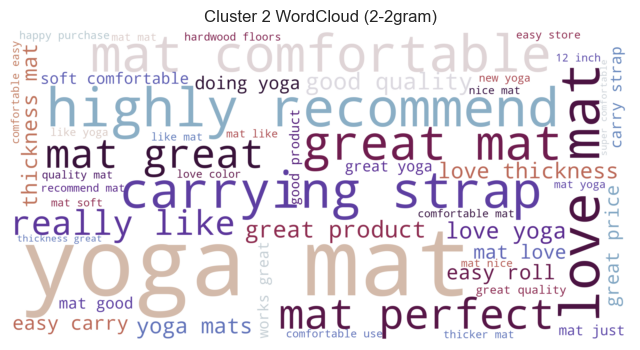

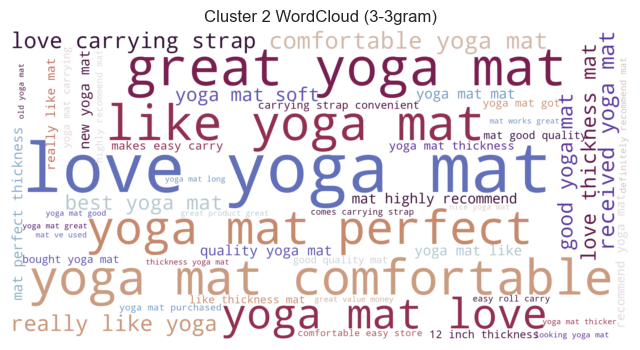

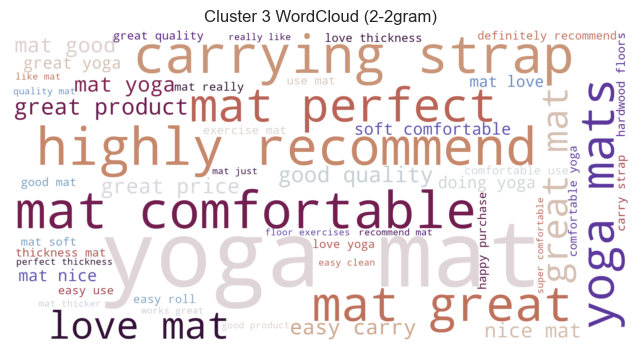

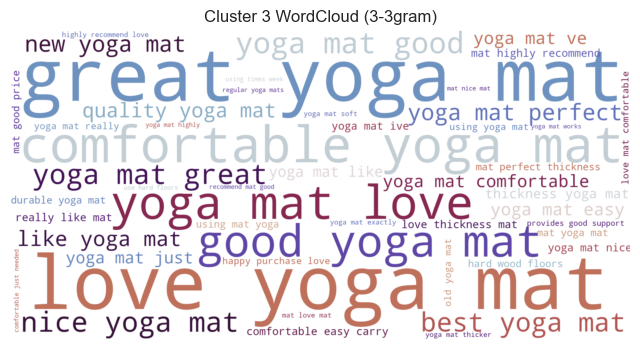

In [53]:
num_clusters = 4
# Create and display word clouds for bigrams and trigrams for each cluster
for cluster_num in range(num_clusters):
    # Save path for the PNG image
    save_path_bigram = f"wordcloud_cluster_{cluster_num}_bigram.png"
    save_path_trigram = f"wordcloud_cluster_{cluster_num}_trigram.png"
    
    create_wordcloud((2, 2), clustered_sentences, cluster_num)  # Bigrams
    create_wordcloud((3, 3), clustered_sentences, cluster_num)  # Trigrams

## Extractive Summarization with sumy library
Using the already processed list of sentences for the Transformers summarization technique, convert the list of sentences into a string for sumy's PlaintextParser function. 
The following algorithms will be used to analyze sumy's summarization: 
#### LSA algorithm
Latent semantic analysis (LSA) assumes that words that are close in meaning will occur in the same documents.

#### Lex Rank
A graphical based text summarizer. 

#### Luhn Summarizer
It scores sentences based on frequency of the most important words. 

#### Text Rank

Sumy's documentation: https://miso-belica.github.io/sumy/

In [42]:
processed_sentences[:10]

['Thick and great price!',
 'good.',
 'It feels durable and is easily rolled for storage.',
 'I would much rather they had ignored the strap and included a bag to protect and carry the mat.',
 "FYI don't use for camping lol.",
 'Such a great mat!',
 "I can't believe the cost.",
 'I love the thickness for knee poses.',
 "I won't have to fold my mat over any longer!",
 'Update took a star away because Im still using my old disgusting mat.']

In [43]:
# Combine all the sentences into a single string
combined_text = ' '.join(processed_sentences)

# Ensure there are no extra delimiters or unexpected characters
cleaned_text = combined_text.replace('\n', ' ').strip()

# Create a PlaintextParser object
parser = PlaintextParser.from_string(cleaned_text, Tokenizer("english"))

# Check the number of sentences and words
sentences = parser.document.sentences
words = sum(len(sentence.words) for sentence in sentences)

print(f"Number of sentences: {len(sentences)}")
print(f"Number of words: {words}")

Number of sentences: 18253
Number of words: 166259


In [ ]:
# Ensure LSA summarizer will work properly
if words > len(sentences):
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 5)  # summarize to 5 sentences

    for sentence in summary:
        print(sentence)
else:
    print("The number of words is lower than the number of sentences. Please check the input text format.")

### Summarization

In [44]:
LANGUAGE = 'english'
def summarize(reviews, summarizer_type, sentence_count=6):
    """
    Summarizes the given string of reviews using the specified summarizer.
    """
    # Initialize parser and stemmer
    parser = PlaintextParser.from_string(reviews, Tokenizer(LANGUAGE))
    stemmer = Stemmer(LANGUAGE)
    
    # Choose the appropriate summarizer
    if summarizer_type == 'lsa':
        summarizer = LsaSummarizer(stemmer)
    elif summarizer_type == 'lexrank':  # keep getting memory size error mesage
        summarizer = LexRankSummarizer(stemmer)
    elif summarizer_type == 'luhn':
        summarizer = LuhnSummarizer(stemmer)
    elif summarizer_type == 'textrank':
        summarizer = TextRankSummarizer(stemmer)
    else:
        raise ValueError("Invalid summarizer type. Choose from 'lsa', 'lexrank', 'luhn', or 'textrank'.")
    
    # Generate the summary
    summary = summarizer(parser.document, sentence_count)
    
    return ' '.join(str(sentence) for sentence in summary)

In [45]:
summarizer_types = ['lsa', 'lexrank', 'luhn', 'textrank']
for summarizer_type in summarizer_types:
    st = time.process_time()
    print(f"Summarizer Type: {summarizer_type}")
    print(summarize(cleaned_text, summarizer_type))
    e = time.process_time()
    print(f"Elapsed time: {e - st} seconds\n")

Summarizer Type: lsa


C:\Users\MJ\anaconda3\Lib\site-packages\sumy\summarizers\lsa.py:76: UserWarning: Number of words (3770) is lower than number of sentences (18253). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


Just wish there was maybe a finish on top of different texture but that doesn't make it any less great. It has a normal light smell of something like new plastic that you might expect but nothing at all overwhelming. The pad is thick enough to be comfortable on my knees and it doesn't move around like some I've had. Not sure if this was just damaged from shipping or what but Im hoping the new one will come undamaged. I have just gotten them so cannot comment on durability but they look really good to me at this point. Very comfortable and large which is nice thick too so you don't feel anything below it such as the floor.
Elapsed time: 398.84375 seconds

Summarizer Type: lexrank
Its the 11th. I love the mat as it's a good thickness and great quality to do yoga and other mat workouts! I use it for yoga and it is great! This mat is perfect for yoga and I LOVE the thickness of it! I like the thickness and comfort in using this yoga mat. It.
Elapsed time: 4591.234375 seconds

Summarizer Ty